# Find Alpha Attribute from Sepsis dataset. clustering/classification

### Reading data

In [1]:
import os
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
import warnings
warnings.simplefilter("ignore")
from pm4py.objects.log.log import EventLog
# from ClusterFlags import bag_of_activities
from pm4py.objects.log.util import get_log_representation as get_
from sklearn.decomposition import PCA
from pm4py.objects.log.obj import EventLog, Trace
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np

### Filtered data = Complete traces - Ending in Release

In [2]:
import pandas as pd
mimic = pd.read_csv('/Users/asadtariq/Downloads/mimicel-mimic-iv-event-log-for-emergency-department-1.0.0/data/mimicel.csv')
mimic.head()

,stay_id,subject_id,hadm_id,timestamps,activity,seq_num,icd_code,icd_version,icd_title,temperature,...,chiefcomplaint,rhythm,name,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn
0,30000012,11714491,21562392.0,2126-02-14 20:22:00,Enter the ED,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30000012,11714491,21562392.0,2126-02-14 20:22:00,Vital sign check,NaN,NaN,NaN,NaN,98.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30000012,11714491,21562392.0,2126-02-14 20:22:01,Triage in the ED,NaN,NaN,NaN,NaN,98.8,...,CHANGE IN MENTAL STATUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,gabapentin,21413.0,1.013506e+10,1.0,6030.0,Anticonvulsant - GABA Analogs,NaN,NaN
4,30000012,11714491,21562392.0,2126-02-14 22:21:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,spironolactone,6818.0,1.672902e+10,2.0,6043.0,Aldosterone Receptor Antagonists,NaN,NaN


### Getting Release Type of every case

In [3]:
mimic.shape

(8320181, 27)

In [4]:
mimic.shape

(8320181, 27)

In [5]:
mimic.tail()

,stay_id,subject_id,hadm_id,timestamps,activity,seq_num,icd_code,icd_version,icd_title,temperature,...,chiefcomplaint,rhythm,name,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn
8320176,39999964,16479007,29821286.0,2130-06-06 18:27:00,Discharge from the ED + diagnosis 1,1.0,F329,10.0,"Major depressive disorder, single episode, uns...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8320177,39999965,14733226,27008423.0,2125-09-14 00:46:00,Enter the ED,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8320178,39999965,14733226,27008423.0,2125-09-14 00:46:01,Triage in the ED,NaN,NaN,NaN,NaN,97.5,...,Labor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8320179,39999965,14733226,27008423.0,2125-09-14 21:22:50,Discharge from the ED + diagnosis 2,2.0,78909,9.0,ABDOMINAL PAIN OTHER SPECIED,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8320180,39999965,14733226,27008423.0,2125-09-14 21:22:50,Discharge from the ED + diagnosis 1,1.0,64893,9.0,OTH CURR COND-ANTEPARTUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


focusing on diagnosis 1

In [6]:
rel =mimic[['stay_id', 'activity','icd_title']]
diagnose = rel[rel['activity'].str.contains('diagnosis 1')]

In [7]:
diagnose

,stay_id,activity,icd_title
21,30000012,Discharge from the ED + diagnosis 1,HEPATIC ENCEPHALOPATHY
25,30000017,Discharge from the ED + diagnosis 1,AC ALCOHOL INTOX-UNSPEC
54,30000038,Discharge from the ED + diagnosis 1,"Pneumonia, unspecified organism"
69,30000039,Discharge from the ED + diagnosis 1,FX LUMBAR VERTEBRA-CLOSE
75,30000055,Discharge from the ED + diagnosis 1,IMPACTED CERUMEN
...,...,...,...
8320106,39999939,Discharge from the ED + diagnosis 1,CHEST PAIN NOS
8320112,39999953,Discharge from the ED + diagnosis 1,HEADACHE
8320140,39999961,Discharge from the ED + diagnosis 1,Other pulmonary embolism without acute cor pul...
8320176,39999964,Discharge from the ED + diagnosis 1,"Major depressive disorder, single episode, uns..."


In [8]:
uniq_diagnose = diagnose['icd_title'].unique()

In [9]:
s = pd.DataFrame(uniq_diagnose)
s.to_csv('unique_diseases.csv')


In [10]:
diagnose

,stay_id,activity,icd_title
21,30000012,Discharge from the ED + diagnosis 1,HEPATIC ENCEPHALOPATHY
25,30000017,Discharge from the ED + diagnosis 1,AC ALCOHOL INTOX-UNSPEC
54,30000038,Discharge from the ED + diagnosis 1,"Pneumonia, unspecified organism"
69,30000039,Discharge from the ED + diagnosis 1,FX LUMBAR VERTEBRA-CLOSE
75,30000055,Discharge from the ED + diagnosis 1,IMPACTED CERUMEN
...,...,...,...
8320106,39999939,Discharge from the ED + diagnosis 1,CHEST PAIN NOS
8320112,39999953,Discharge from the ED + diagnosis 1,HEADACHE
8320140,39999961,Discharge from the ED + diagnosis 1,Other pulmonary embolism without acute cor pul...
8320176,39999964,Discharge from the ED + diagnosis 1,"Major depressive disorder, single episode, uns..."


In [11]:
diagnose.loc[diagnose.icd_title.str.contains("1 DEG BURN "), 'icd_title'] = '1ST DEG BURN'
diagnose.loc[diagnose.icd_title.str.contains("1ST DEG BURN "), 'icd_title'] = '1ST DEG BURN'
diagnose.loc[diagnose.icd_title.str.contains("2 DEG BURN "), 'icd_title'] = '2ND DEG BURN'
diagnose.loc[diagnose.icd_title.str.contains("2ND DEG BURN "), 'icd_title'] = '2ND DEG BURN'
diagnose.loc[diagnose.icd_title.str.contains("3RD DEG BURN "), 'icd_title'] = '3RD DEG BURN'
diagnose.loc[diagnose.icd_title.str.contains("ABDOM "), 'icd_title'] = 'Abdominal'
diagnose.loc[diagnose.icd_title.str.contains("Abdominal "), 'icd_title'] = 'Abdominal'
diagnose.loc[diagnose.icd_title.str.contains("ABDOMINAL "), 'icd_title'] = 'Abdominal'
diagnose.loc[diagnose.icd_title.str.contains("ABN "), 'icd_title'] = 'Abnormality in initial findings'
diagnose.loc[diagnose.icd_title.str.contains("Abn "), 'icd_title'] = 'Abnormality in initial findings'
diagnose.loc[diagnose.icd_title.str.contains("Abnormal "), 'icd_title'] = 'Abnormality in initial findings'
diagnose.loc[diagnose.icd_title.str.contains("ABNORMAL "), 'icd_title'] = 'Abnormality in initial findings'
diagnose.loc[diagnose.icd_title.str.contains("ABNORMAITY "), 'icd_title'] = 'Abnormality in initial findings'
diagnose.loc[diagnose.icd_title.str.contains("ABRASION "), 'icd_title'] = 'Abrasion'
diagnose.loc[diagnose.icd_title.str.contains("Abrasion "), 'icd_title'] = 'Abrasion'
diagnose.loc[diagnose.icd_title.str.contains("Abscess "), 'icd_title'] = 'Abscess'
diagnose.loc[diagnose.icd_title.str.contains("ABSCESS "), 'icd_title'] = 'Abscess'
diagnose.loc[diagnose.icd_title.str.contains("ALCOHOL "), 'icd_title'] = 'Alcohol'
diagnose.loc[diagnose.icd_title.str.contains("OSTEOMYELITIS "), 'icd_title'] = 'OSTEOMYELITIS'
diagnose.loc[diagnose.icd_title.str.contains("Acute "), 'icd_title'] = 'Acute'
diagnose.loc[diagnose.icd_title.str.contains("ACUTE "), 'icd_title'] = 'Acute'
diagnose.loc[diagnose.icd_title.str.contains("Adjustment "), 'icd_title'] = 'Adjustment'
diagnose.loc[diagnose.icd_title.str.contains("ADJ REACT "), 'icd_title'] = 'Adjustment'
diagnose.loc[diagnose.icd_title.str.contains("ADJUSTMENT "), 'icd_title'] = 'Adjustment'
diagnose.loc[diagnose.icd_title.str.contains("Adverse "), 'icd_title'] = 'Adverse'
diagnose.loc[diagnose.icd_title.str.contains("ADVERSE "), 'icd_title'] = 'Adverse'
diagnose.loc[diagnose.icd_title.str.contains("Allergic "), 'icd_title'] = 'Allergic'
diagnose.loc[diagnose.icd_title.str.contains("ALLERGIC "), 'icd_title'] = 'Allergic'
diagnose.loc[diagnose.icd_title.str.contains("ALLERGY "), 'icd_title'] = 'Allergic'
diagnose.loc[diagnose.icd_title.str.contains("Allergy "), 'icd_title'] = 'Allergic'
diagnose.loc[diagnose.icd_title.str.contains("Anaphylactic reaction "), 'icd_title'] = 'Anaphylactic reaction'
diagnose.loc[diagnose.icd_title.str.contains("ANAPHYLACTIC REACTION "), 'icd_title'] = 'Anaphylactic reaction'
diagnose.loc[diagnose.icd_title.str.contains("Anemia "), 'icd_title'] = 'Anemia'
diagnose.loc[diagnose.icd_title.str.contains("ANEMIA "), 'icd_title'] = 'Anemia'
diagnose.loc[diagnose.icd_title.str.contains("Aneurysm "), 'icd_title'] = 'Aneurysm'
diagnose.loc[diagnose.icd_title.str.contains("Aneurysm "), 'icd_title'] = 'Aneurysm'



diagnose

,stay_id,activity,icd_title
21,30000012,Discharge from the ED + diagnosis 1,HEPATIC ENCEPHALOPATHY
25,30000017,Discharge from the ED + diagnosis 1,Alcohol
54,30000038,Discharge from the ED + diagnosis 1,"Pneumonia, unspecified organism"
69,30000039,Discharge from the ED + diagnosis 1,FX LUMBAR VERTEBRA-CLOSE
75,30000055,Discharge from the ED + diagnosis 1,IMPACTED CERUMEN
...,...,...,...
8320106,39999939,Discharge from the ED + diagnosis 1,CHEST PAIN NOS
8320112,39999953,Discharge from the ED + diagnosis 1,HEADACHE
8320140,39999961,Discharge from the ED + diagnosis 1,Other pulmonary embolism without acute cor pul...
8320176,39999964,Discharge from the ED + diagnosis 1,"Major depressive disorder, single episode, uns..."


In [12]:
diagnose.to_csv('Datasets/Diagnosis_replaced.csv')

In [13]:
len(rel.icd_title.unique())

13428

In [14]:
diagnose['activity'] = diagnose['activity'].apply(lambda x: x.replace("Discharge from the ED + ", ""))
diagnose

,stay_id,activity,icd_title
21,30000012,diagnosis 1,HEPATIC ENCEPHALOPATHY
25,30000017,diagnosis 1,Alcohol
54,30000038,diagnosis 1,"Pneumonia, unspecified organism"
69,30000039,diagnosis 1,FX LUMBAR VERTEBRA-CLOSE
75,30000055,diagnosis 1,IMPACTED CERUMEN
...,...,...,...
8320106,39999939,diagnosis 1,CHEST PAIN NOS
8320112,39999953,diagnosis 1,HEADACHE
8320140,39999961,diagnosis 1,Other pulmonary embolism without acute cor pul...
8320176,39999964,diagnosis 1,"Major depressive disorder, single episode, uns..."


In [15]:
diagnose = diagnose[['stay_id','icd_title']]
diagnose

,stay_id,icd_title
21,30000012,HEPATIC ENCEPHALOPATHY
25,30000017,Alcohol
54,30000038,"Pneumonia, unspecified organism"
69,30000039,FX LUMBAR VERTEBRA-CLOSE
75,30000055,IMPACTED CERUMEN
...,...,...
8320106,39999939,CHEST PAIN NOS
8320112,39999953,HEADACHE
8320140,39999961,Other pulmonary embolism without acute cor pul...
8320176,39999964,"Major depressive disorder, single episode, uns..."


In [16]:
df = mimic.loc[mimic['activity'].isin(['Vital sign check','Triage in the ED'])]
df.head()

,stay_id,subject_id,hadm_id,timestamps,activity,seq_num,icd_code,icd_version,icd_title,temperature,...,chiefcomplaint,rhythm,name,gsn,ndc,etc_rn,etccode,etcdescription,med_rn,gsn_rn
1,30000012,11714491,21562392.0,2126-02-14 20:22:00,Vital sign check,NaN,NaN,NaN,NaN,98.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30000012,11714491,21562392.0,2126-02-14 20:22:01,Triage in the ED,NaN,NaN,NaN,NaN,98.8,...,CHANGE IN MENTAL STATUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,30000012,11714491,21562392.0,2126-02-14 23:43:00,Vital sign check,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,30000012,11714491,21562392.0,2126-02-15 00:50:00,Vital sign check,NaN,NaN,NaN,NaN,98.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,30000017,14230614,NaN,2185-06-18 11:51:01,Triage in the ED,NaN,NaN,NaN,NaN,NaN,...,"ETOH, Unable to ambulate",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df.columns

Index(['stay_id', 'subject_id', 'hadm_id', 'timestamps', 'activity', 'seq_num',
       'icd_code', 'icd_version', 'icd_title', 'temperature', 'heartrate',
       'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint',
       'rhythm', 'name', 'gsn', 'ndc', 'etc_rn', 'etccode', 'etcdescription',
       'med_rn', 'gsn_rn'],
      dtype='object')

In [18]:
df2 = df[['stay_id', 'temperature', 'heartrate',
       'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']]
df2.head()

,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
1,30000012,98.8,96.0,18.0,93.0,160.0,54.0,0,NaN,NaN
2,30000012,98.8,96.0,18.0,93.0,160.0,54.0,0,2.0,CHANGE IN MENTAL STATUS
12,30000012,NaN,80.0,13.0,99.0,112.0,44.0,0,NaN,NaN
19,30000012,98.6,88.0,16.0,100.0,135.0,51.0,0,NaN,NaN
24,30000017,NaN,73.0,18.0,97.0,156.0,112.0,0,3.0,"ETOH, Unable to ambulate"


In [19]:
df2.shape

(2100091, 10)

In [20]:
complaint = df[['stay_id','chiefcomplaint']]
complaint = complaint.dropna()
complaint.shape

(448949, 2)

In [21]:
df3 = df2.groupby('stay_id', as_index=False, sort=False)['temperature', 'heartrate',
       'resprate', 'o2sat', 'sbp', 'dbp', 'acuity'].first()

df3.head()

,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
0,30000012,98.8,96.0,18.0,93.0,160.0,54.0,2.0
1,30000017,97.7,73.0,18.0,97.0,156.0,112.0,3.0
2,30000038,97.1,54.0,18.0,95.0,143.0,73.0,3.0
3,30000039,98.6,85.0,16.0,98.0,189.0,96.0,3.0
4,30000055,99.4,85.0,16.0,100.0,NaN,NaN,3.0


In [22]:
df3.shape

(448972, 8)

In [23]:
result = pd.merge(df3, complaint)
result.head(10)

,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,chiefcomplaint
0,30000012,98.8,96.0,18.0,93.0,160.0,54.0,2.0,CHANGE IN MENTAL STATUS
1,30000017,97.7,73.0,18.0,97.0,156.0,112.0,3.0,"ETOH, Unable to ambulate"
2,30000038,97.1,54.0,18.0,95.0,143.0,73.0,3.0,Cough
3,30000039,98.6,85.0,16.0,98.0,189.0,96.0,3.0,s/p Fall
4,30000055,99.4,85.0,16.0,100.0,NaN,NaN,3.0,L Ear pain
5,30000094,98.1,60.0,18.0,94.0,120.0,95.0,2.0,N
6,30000112,98.9,85.0,18.0,100.0,123.0,75.0,3.0,Abnormal labs
7,30000177,97.8,106.0,18.0,100.0,190.0,112.0,2.0,"Abd pain, Vomiting"
8,30000202,97.8,93.0,18.0,93.0,140.0,70.0,2.0,ALLERGIC REACTION
9,30000204,99.6,100.0,16.0,96.0,146.0,96.0,3.0,S/P ASSAULT


In [24]:
result.shape

(448949, 9)

In [25]:
# diag =diagnose.groupby(['stay_id','activity'], as_index=False, sort=False)['activity'].agg(['count']).reset_index()
# diag

In [26]:
# diag2 = diag.pivot_table(values='count', columns='activity', index='stay_id')
# diag2.columns.name = None
# diag2 = diag2.reset_index()

# diag2

In [27]:
merged = pd.merge(result, diagnose)
merged.head(10)

,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,chiefcomplaint,icd_title
0,30000012,98.8,96.0,18.0,93.0,160.0,54.0,2.0,CHANGE IN MENTAL STATUS,HEPATIC ENCEPHALOPATHY
1,30000017,97.7,73.0,18.0,97.0,156.0,112.0,3.0,"ETOH, Unable to ambulate",Alcohol
2,30000038,97.1,54.0,18.0,95.0,143.0,73.0,3.0,Cough,"Pneumonia, unspecified organism"
3,30000039,98.6,85.0,16.0,98.0,189.0,96.0,3.0,s/p Fall,FX LUMBAR VERTEBRA-CLOSE
4,30000055,99.4,85.0,16.0,100.0,NaN,NaN,3.0,L Ear pain,IMPACTED CERUMEN
5,30000094,98.1,60.0,18.0,94.0,120.0,95.0,2.0,N,Unspecified atrial fibrillation
6,30000112,98.9,85.0,18.0,100.0,123.0,75.0,3.0,Abnormal labs,"Iron deficiency anemia, unspecified"
7,30000177,97.8,106.0,18.0,100.0,190.0,112.0,2.0,"Abd pain, Vomiting",DIAB NEURO MANIF IDDM
8,30000202,97.8,93.0,18.0,93.0,140.0,70.0,2.0,ALLERGIC REACTION,"ALLERGY, UNSPECIFIED"
9,30000204,99.6,100.0,16.0,96.0,146.0,96.0,3.0,S/P ASSAULT,MAJOR DEPRESSION-UNSPEC


In [28]:
# merged = result.merge(diag2, how='inner', on='stay_id')
# merged

In [29]:
merged.shape

(447757, 10)

In [30]:
count_events = mimic[['stay_id','activity']]
count_events_and_tests= count_events.groupby('stay_id')[['activity']].count()
count_events_and_tests.head()


,activity
stay_id,
30000012,23
30000017,14
30000038,19
30000039,17
30000055,5


In [31]:
processed_data = merged.merge(count_events_and_tests, how='inner', on='stay_id')
processed_data.shape

(447757, 11)

In [32]:
processed_data

,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,chiefcomplaint,icd_title,activity
0,30000012,98.8,96.0,18.0,93.0,160.0,54.0,2.0,CHANGE IN MENTAL STATUS,HEPATIC ENCEPHALOPATHY,23
1,30000017,97.7,73.0,18.0,97.0,156.0,112.0,3.0,"ETOH, Unable to ambulate",Alcohol,14
2,30000038,97.1,54.0,18.0,95.0,143.0,73.0,3.0,Cough,"Pneumonia, unspecified organism",19
3,30000039,98.6,85.0,16.0,98.0,189.0,96.0,3.0,s/p Fall,FX LUMBAR VERTEBRA-CLOSE,17
4,30000055,99.4,85.0,16.0,100.0,NaN,NaN,3.0,L Ear pain,IMPACTED CERUMEN,5
...,...,...,...,...,...,...,...,...,...,...,...
447752,39999939,98.4,84.0,16.0,97.0,152.0,90.0,2.0,Chest pain,CHEST PAIN NOS,22
447753,39999953,98.2,108.0,18.0,100.0,155.0,94.0,3.0,"Palpitations, Dizziness, Headache",HEADACHE,6
447754,39999961,99.3,119.0,22.0,100.0,132.0,74.0,2.0,"Chest pain, Cough, Dyspnea",Other pulmonary embolism without acute cor pul...,28
447755,39999964,98.6,64.0,18.0,99.0,127.0,64.0,2.0,"SI, Depression","Major depressive disorder, single episode, uns...",34


### Dropping nan values from columns other than diagnosis

In [33]:
processed_data.isna().sum()

stay_id              0
temperature       6941
heartrate         5254
resprate          5462
o2sat             5794
sbp               5491
dbp               5549
acuity            7232
chiefcomplaint       0
icd_title            0
activity             0
dtype: int64

In [34]:
processed_data.columns

Index(['stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp',
       'dbp', 'acuity', 'chiefcomplaint', 'icd_title', 'activity'],
      dtype='object')

In [35]:

processed_data.dropna(subset=['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp',
       'dbp', 'acuity', 'chiefcomplaint'],inplace=True)
processed_data.isna().sum()

stay_id           0
temperature       0
heartrate         0
resprate          0
o2sat             0
sbp               0
dbp               0
acuity            0
chiefcomplaint    0
icd_title         0
activity          0
dtype: int64

In [36]:
# Encoding Diagnose and Release Type categorical features
processed_data[['chiefcomplaint']] = processed_data[['chiefcomplaint']].apply(lambda x: pd.factorize(x)[0])
processed_data[['icd_title']] = processed_data[['icd_title']].apply(lambda x: pd.factorize(x)[0])


processed_data.head()

,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,chiefcomplaint,icd_title,activity
0,30000012,98.8,96.0,18.0,93.0,160.0,54.0,2.0,0,0,23
1,30000017,97.7,73.0,18.0,97.0,156.0,112.0,3.0,1,1,14
2,30000038,97.1,54.0,18.0,95.0,143.0,73.0,3.0,2,2,19
3,30000039,98.6,85.0,16.0,98.0,189.0,96.0,3.0,3,3,17
5,30000094,98.1,60.0,18.0,94.0,120.0,95.0,2.0,4,4,16


In [42]:
descriptive_features =  processed_data.loc[:, processed_data.columns != 'stay_id']
descriptive_features =  descriptive_features.loc[:, descriptive_features.columns != 'activity']
descriptive_features

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,chiefcomplaint,icd_title
0,98.8,96.0,18.0,93.0,160.0,54.0,2.0,0,0
1,97.7,73.0,18.0,97.0,156.0,112.0,3.0,1,1
2,97.1,54.0,18.0,95.0,143.0,73.0,3.0,2,2
3,98.6,85.0,16.0,98.0,189.0,96.0,3.0,3,3
5,98.1,60.0,18.0,94.0,120.0,95.0,2.0,4,4
...,...,...,...,...,...,...,...,...,...
447752,98.4,84.0,16.0,97.0,152.0,90.0,2.0,47,39
447753,98.2,108.0,18.0,100.0,155.0,94.0,3.0,22176,134
447754,99.3,119.0,22.0,100.0,132.0,74.0,2.0,2933,154
447755,98.6,64.0,18.0,99.0,127.0,64.0,2.0,1158,180


In [111]:
target = processed_data['activity']
target

0         23
1         14
2         19
3         17
5         16
          ..
447752    22
447753     6
447754    28
447755    34
447756     4
Name: activity, Length: 436737, dtype: int64

In [112]:
numerical_features = descriptive_features.iloc[:,0:7]
numerical_columns = numerical_features.columns
numerical_columns

Index(['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp',
       'acuity'],
      dtype='object')

In [113]:

from sklearn import preprocessing


min_max_scaler = preprocessing.MinMaxScaler()
descriptive_features[numerical_columns]  = min_max_scaler.fit_transform(descriptive_features[numerical_columns] )
descriptive_features

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,chiefcomplaint,icd_title
0,0.100112,0.077425,0.001270,0.009976,0.001052,0.000082,0.25,0,0
1,0.098996,0.058680,0.001270,0.010405,0.001026,0.000169,0.50,1,1
2,0.098387,0.043195,0.001270,0.010191,0.000940,0.000110,0.50,2,2
3,0.099909,0.068460,0.001129,0.010513,0.001244,0.000145,0.50,3,3
5,0.099402,0.048085,0.001270,0.010084,0.000788,0.000144,0.25,4,4
...,...,...,...,...,...,...,...,...,...
447752,0.099706,0.067645,0.001129,0.010405,0.000999,0.000136,0.25,47,39
447753,0.099503,0.087205,0.001270,0.010727,0.001019,0.000142,0.50,22176,134
447754,0.100619,0.096170,0.001553,0.010727,0.000867,0.000112,0.25,2933,154
447755,0.099909,0.051345,0.001270,0.010620,0.000834,0.000097,0.25,1158,180


In [41]:
descriptive_features

array([[1.00111573e-01, 7.74246129e-02, 1.27037900e-03, ...,
        2.50000000e-01, 0.00000000e+00, 0.00000000e+00],
       [9.89958414e-02, 5.86797066e-02, 1.27037900e-03, ...,
        5.00000000e-01, 1.62972621e-05, 1.12625296e-04],
       [9.83872604e-02, 4.31947840e-02, 1.27037900e-03, ...,
        5.00000000e-01, 3.25945241e-05, 2.25250591e-04],
       ...,
       [1.00618724e-01, 9.61695192e-02, 1.55268544e-03, ...,
        2.50000000e-01, 4.77998696e-02, 1.73442955e-02],
       [9.99087129e-02, 5.13447433e-02, 1.27037900e-03, ...,
        2.50000000e-01, 1.88722295e-02, 2.02725532e-02],
       [9.87929810e-02, 5.21597392e-02, 1.12922577e-03, ...,
        2.50000000e-01, 6.74054759e-02, 2.77058227e-02]])

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training set

random_forest_classifier.fit(descriptive_features, target)

# Predict on the test set results

y_pred_100 = random_forest_classifier.predict(descriptive_features)

# Check accuracy score 

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(target, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.9999


In [120]:
# view the feature scores

feature_scores = pd.Series(random_forest_classifier.feature_importances_, index=descriptive_features.columns).sort_values(ascending=False)
feature_scores

chiefcomplaint    0.161736
heartrate         0.154381
icd_title         0.151466
sbp               0.147437
temperature       0.144657
dbp               0.140738
resprate          0.051546
o2sat             0.036958
acuity            0.011081
dtype: float64

Text(0.5, 1.0, 'Classification - Important Features')

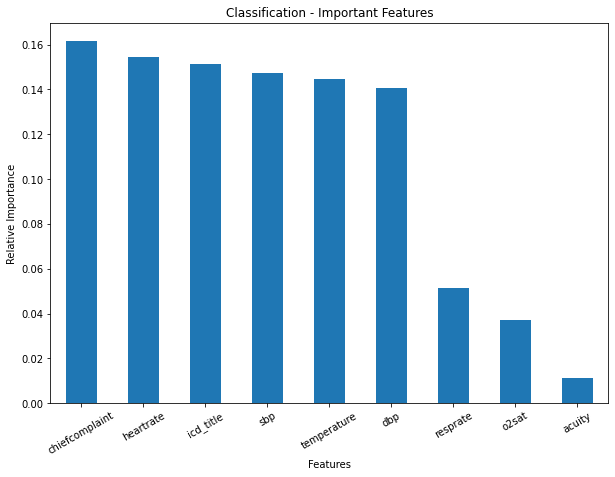

In [122]:

feature_scores.nlargest(10).plot(kind='bar',figsize=(10,7))
plt.xticks(rotation=30)
plt.ylabel("Relative Importance")
plt.xlabel("Features")
plt.title("Classification - Important Features")

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set

random_forest_classifier.fit(descriptive_features, target)

# Predict on the test set results

y_pred_100 = random_forest_classifier.predict(descriptive_features)

# Check accuracy score 

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(target, y_pred_100)))

KeyboardInterrupt: 

In [118]:
# view the feature scores

feature_scores = pd.Series(random_forest_classifier.feature_importances_, index=descriptive_features.columns).sort_values(ascending=False)
feature_scores

temperature       0.0
heartrate         0.0
resprate          0.0
o2sat             0.0
sbp               0.0
dbp               0.0
acuity            0.0
chiefcomplaint    0.0
icd_title         0.0
dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'heartrate'),
  Text(1, 0, 'sbp'),
  Text(2, 0, 'dbp'),
  Text(3, 0, 'chiefcomplaint'),
  Text(4, 0, 'temperature'),
  Text(5, 0, 'icd_title'),
  Text(6, 0, 'resprate'),
  Text(7, 0, 'o2sat'),
  Text(8, 0, 'acuity')])

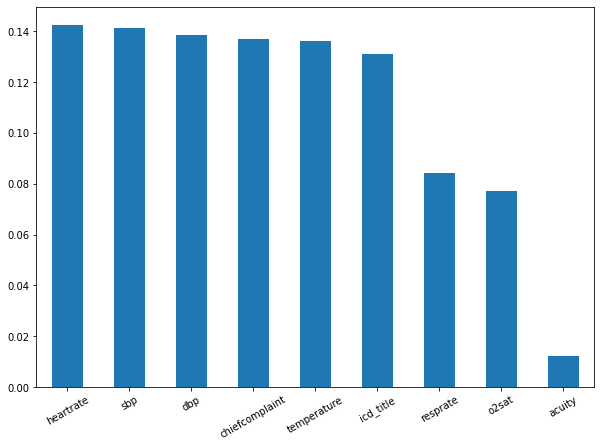

In [ ]:

feature_scores.nlargest(10).plot(kind='bar',figsize=(10,7))
plt.xticks(rotation=30)

In [ ]:
descriptive_features

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,chiefcomplaint,icd_title
0,98.733333,90.000000,16.250000,96.250000,141.750000,50.750000,2.0,0,0
1,97.700000,71.500000,19.000000,97.000000,149.000000,101.000000,3.0,1,1
2,97.933333,66.500000,19.000000,95.500000,142.750000,66.500000,3.0,2,2
3,98.040000,87.833333,18.666667,96.500000,172.857143,90.142857,3.0,3,3
5,98.033333,72.000000,18.833333,96.000000,116.166667,80.333333,2.0,4,4
...,...,...,...,...,...,...,...,...,...
447752,98.225000,73.875000,16.571429,97.833333,127.500000,82.166667,2.0,47,39
447753,98.250000,94.500000,17.000000,100.000000,139.500000,90.000000,3.0,22176,134
447754,98.866667,109.600000,20.000000,99.000000,129.000000,76.800000,2.0,2933,154
447755,98.373333,65.428571,17.714286,98.857143,133.571429,70.857143,2.0,1158,180


In [ ]:
numerical_features = descriptive_features.iloc[:,0:7]
numerical_columns = numerical_features.columns
numerical_columns

Index(['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp',
       'acuity'],
      dtype='object')

In [43]:

from sklearn import preprocessing


min_max_scaler = preprocessing.MinMaxScaler()
descriptive_features2 = min_max_scaler.fit_transform(descriptive_features )
descriptive_features2

array([[1.00111573e-01, 7.74246129e-02, 1.27037900e-03, ...,
        2.50000000e-01, 0.00000000e+00, 0.00000000e+00],
       [9.89958414e-02, 5.86797066e-02, 1.27037900e-03, ...,
        5.00000000e-01, 1.62972621e-05, 1.12625296e-04],
       [9.83872604e-02, 4.31947840e-02, 1.27037900e-03, ...,
        5.00000000e-01, 3.25945241e-05, 2.25250591e-04],
       ...,
       [1.00618724e-01, 9.61695192e-02, 1.55268544e-03, ...,
        2.50000000e-01, 4.77998696e-02, 1.73442955e-02],
       [9.99087129e-02, 5.13447433e-02, 1.27037900e-03, ...,
        2.50000000e-01, 1.88722295e-02, 2.02725532e-02],
       [9.87929810e-02, 5.21597392e-02, 1.12922577e-03, ...,
        2.50000000e-01, 6.74054759e-02, 2.77058227e-02]])

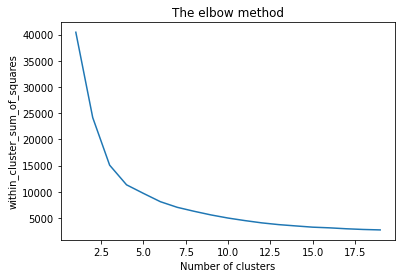

In [53]:

from sklearn.cluster import KMeans
within_cluster_sum_of_squares = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(descriptive_features2)
    within_cluster_sum_of_squares.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 20), within_cluster_sum_of_squares)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('within_cluster_sum_of_squares') #within cluster sum of squares
plt.show()


In [39]:
# Wrapper of Random Forest classifier on K means
class Kmeans_Custom_RF(KMeans):
    def __init__(self, ordered_features, method='wcss_min', **kwargs):
        super().__init__(**kwargs)
        self.method = method
        self.ordered_features = ordered_features

    def fit(self, X, y=None, sample_weight=None):
        super().fit(X, y, sample_weight)
        
        if self.method == 'unsup2sup':
            self.important_features = self.get_importance_unsup2sup(X)
        
        elif self.method == 'wcss_min':
            self.important_features = self.get_importance_wcss_min()
        return self

    def get_importance_wcss_min(self):
        labels = self.n_clusters
        centroids = np.abs(self.cluster_centers_)
        sorted_centroid_features_idx = np.argsort(centroids, axis=1)[:,::-1]

        weighted_features = {}
        for label, centroid in enumerate(sorted_centroid_features_idx):
            ordered_weights = centroids[label][centroid]
            ordered_features = [self.ordered_features[feature] for feature in centroid]
            weighted_features[label] = list(zip(ordered_features, ordered_weights))
        
        return weighted_features

    def get_importance_unsup2sup(self, X):

        weighted_features = {}
        for label in range(self.n_clusters):
            binary_encoding = np.array([1 if x == label else 0 for x in self.labels_])
            classifier = RandomForestClassifier()
            classifier.fit(X, binary_encoding)

            sorted_features_idx = np.argsort(classifier.feature_importances_)[::-1]
            ordered_features = np.array(self.ordered_features)[sorted_features_idx]
            ordered_weights = classifier.feature_importances_[sorted_features_idx]
            weighted_features[label] = list(zip(ordered_features, ordered_weights))
        return weighted_features

In [58]:

kms = Kmeans_Custom_RF(
	n_clusters=4,
	ordered_feature_names=descriptive_features.columns.tolist(), 
	feature_importance_method='wcss_min', # or 'unsup2sup'
).fit(descriptive_features2)

# A dictionary where the key [0] is the cluster label, and [:10] will refer to the first 10 most important features
kms.feature_importances_[0][:10] # Features here are words


[('icd_title', 0.515034411550516),
 ('acuity', 0.4424605051556163),
 ('temperature', 0.0992856729512462),
 ('chiefcomplaint', 0.08410684405455036),
 ('heartrate', 0.06781705141706057),
 ('o2sat', 0.010614888575085222),
 ('resprate', 0.0012250459921354661),
 ('sbp', 0.0008892293739659835),
 ('dbp', 0.00016696886184528796)]

In [55]:
features_kms = pd.DataFrame(kms.feature_importances_[0][0:] )
features_kms.set_index(0,inplace=True)
features_kms


,1
0,
icd_title,0.514904
acuity,0.442493
temperature,0.099286
chiefcomplaint,0.084113
heartrate,0.067820
o2sat,0.010615
resprate,0.001225
sbp,0.000889
dbp,0.000167


Text(0.5, 1.0, 'Clustering - Important Features')

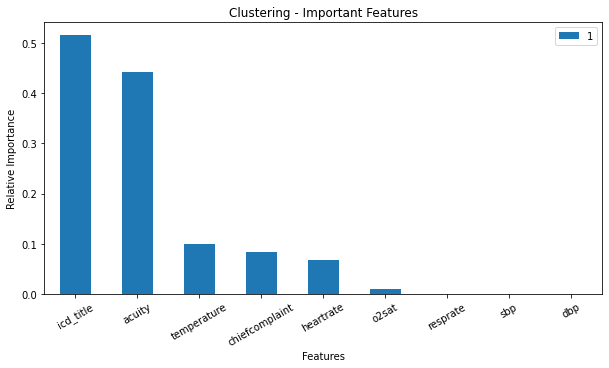

In [56]:
features_kms.plot.bar(figsize=(10,5))
plt.xticks(rotation=30)
plt.ylabel("Relative Importance")
plt.xlabel("Features")
plt.title("Clustering - Important Features")

In [60]:
silhouette_avg = silhouette_score(descriptive_features, kmeans.labels_)
silhouette_avg

KeyboardInterrupt: 

In [ ]:
silhouette_avg = silhouette_score(merged, kmeans.labels_)
silhouette_avg2 = silhouette_score(merged, kmeans2.labels_)
silhouette_avg3 = silhouette_score(merged, kmeans3.labels_)
silhouette_avg,silhouette_avg2,silhouette_avg3

values = [silhouette_avg,silhouette_avg2,silhouette_avg3]
print('Silhouette average scores for each clustering method are :', values)


# Set the labels for the x-axis (optional)
labels = ['Cluster Simple', 'Cluster PCA', 'Cluster Normalised']
# Create a bar plot
plt.bar(range(len(values)), values)

# Set the x-tick labels to the labels we defined earlier
plt.xticks(range(len(values)), labels)

# Add a title and axis labels
plt.title('Comparison of clustering method.')
plt.xlabel('Method')
plt.ylabel('Score')

# Set the x-tick labels to the labels we defined earlier
plt.xticks(range(len(values)), labels)

# Display the plot
plt.show()